In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.integrate as spint
import scipy.interpolate as spinterp
import pandas as pd
import scipy.optimize as spopt

1)Firstly the data of cluster_members.txt file are read and then they are cleaned from missing values.Then,chosing the galaxy cluster NGC 2506 and cleaning the data with membership probability smaller than 1 (PMemb<1),which practically means PMemb=1 but for illustration reasons I use PMemb>=1.Also the scatter plot of $(BP-RP(Colour))-G_{magnitude}$ with inverted $G_{magnitude}$ axis is shown:

After cleaning the missing values: 395783 rows remaining
After cleaning the missing values: 5663 rows cleaned
Data of cluster NGC 2506 after cleaning the data with membership probability smaller than 1: 1145 rows remaining


Text(0.5, 1.0, 'Galaxy cluster:NGC 2506')

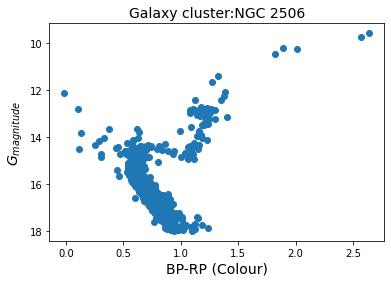

In [2]:
#names of all the cluster_members.txt columns as a list:
names_c=['RAdeg','DEdeg','Source','GLON', 'GLAT','plx','e_plx','pmRA','e_pmRA','pmDE','e_pmDE','RADEcor',
         'RAPlxcor','RApmRAcor','RApmDEcor','DEPlxcor','DEpmRAcor','DEpmDEcor','PlxpmRAcor','PlxpmDEcor',
         'pmRApmDEcor','o_Gmag','Gmag','BP-RP' ,'PMemb' ,'Cluster']

#Reading and cleaning the missing values of cluster_members.txt:
cluster_members = pd.read_csv('cluster_members.txt', delim_whitespace=True,skiprows=1, skipfooter=2, engine='python',
names=names_c,index_col=False, na_values='---')
cnew = cluster_members[:].dropna(how="any") 
print("After cleaning the missing values:",len(cnew),"rows remaining")
print("After cleaning the missing values:",len(cluster_members)-len(cnew),"rows cleaned")

#Choosing the data of cluster NGC 2506 and cleaning its data by PMemb>=1:
cluster_NGC2506= cnew[cnew.Cluster=='NGC_2506']
cluster_NGC2506=cluster_NGC2506[cluster_NGC2506.PMemb>=1]
print("Data of cluster NGC 2506 after cleaning the data with membership probability smaller than 1:",
      len(cluster_NGC2506),"rows remaining")

#Scatter plot of BP-RP,Gmag of "cleaned" data of cluster NGC 2506:
plt.scatter(cluster_NGC2506['BP-RP'],cluster_NGC2506['Gmag'])
#Built in function of pyplot for inverting the y axis:
plt.gca().invert_yaxis()
plt.xlabel("BP-RP (Colour)", fontsize=14)
plt.ylabel(r"$G_{magnitude}$", fontsize=14)
plt.title("Galaxy cluster:NGC 2506", fontsize=14)

### 2) a)
Below the scatter plot of the parallax and the $G_{magnitude}$ for NGC 2506 galaxy cluster.This plot has a
funnel-like appearance as expected,due to the fact that all stars are part of the same cluster and so their distance from earth is almost equal in kpc units.Their $G_{magnitude}$ is affected by the redshift changes due to the acceleration of the universe and in a smaller order of magnitude by the stars' proper motion,most of the stars $G_{magnitude}$ values are expected to be within a small "band". For field stars there are high differences between stars' distance from earth and the $G_{magnitude}$ would be highly correlated with the distance and so with the parallax (which is highly affected by the distance),showing a monotonically increasing relation in the same scatter plot as below (with inversed $G_{magnitude}$ axis).

Text(0.5, 1.0, 'Galaxy cluster:NGC 2506')

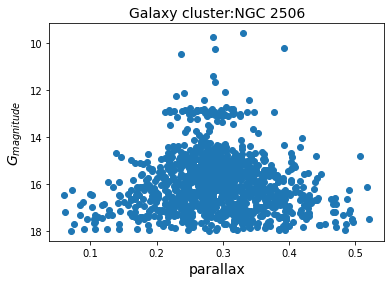

In [3]:
plt.scatter(cluster_NGC2506['plx'],cluster_NGC2506['Gmag'])
plt.gca().invert_yaxis()
plt.xlabel("parallax", fontsize=14)
plt.ylabel(r"$G_{magnitude}$", fontsize=14)
plt.title("Galaxy cluster:NGC 2506", fontsize=14)

### 2)b) 
In this part we have to determine whether or not the parallax is corellated on the G magnitude.

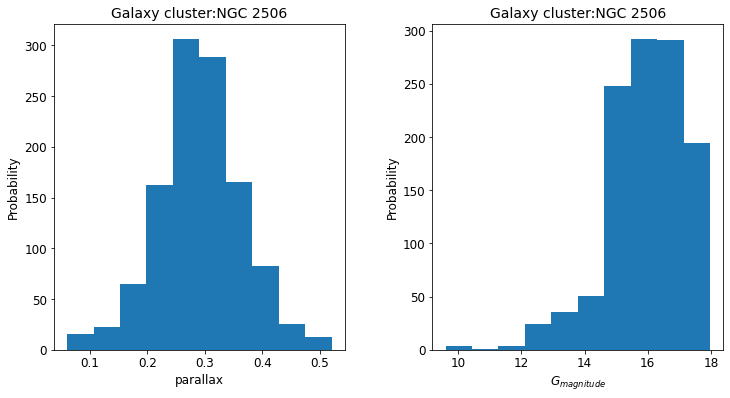

Cluster NGC 2506 data size: 1145
Pearson's r and p-value: 0.026825933692502562 0.36445776827423987
Spearman's rho and p-value: 0.04153825850873356 0.16012945023860628 



In [4]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
fig.subplots_adjust(wspace=0.3)

ax1.hist(cluster_NGC2506['plx'])
ax2.hist(cluster_NGC2506['Gmag'])

for ax in (ax1,ax2):
    ax.tick_params(labelsize=12)
    ax.set_ylabel("Probability", fontsize=12)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_title("Galaxy cluster:NGC 2506", fontsize=14)

ax1.set_xlabel("parallax", fontsize=12)
ax2.set_xlabel(r"$G_{magnitude}$", fontsize=12)
plt.show()

#Size of cluster NGC 2506 data:
print("Cluster NGC 2506 data size:",len(cluster_NGC2506['Gmag']))
#Calculation of NGC 2506 G_magnitude and parallax values's Pearson's r,p-value and Spearman's rho,p-value:":
(rcor, rpval) = sps.pearsonr(cluster_NGC2506['plx'],cluster_NGC2506['Gmag'])
(rhocor, rhopval) = sps.spearmanr(cluster_NGC2506['plx'],cluster_NGC2506['Gmag'])
print("Pearson's r and p-value:",rcor, rpval)
print("Spearman's rho and p-value:",rhocor, rhopval ,"\n")

We can see that the distribution of parallax is close to the normal distribution and the distribution of $G_{magnitude}$ is close to the lognormal distribution.Regarding also that the data set is large ($n_{sample}>500$) and the correlation coefficients are calculated from the sums of those variates the central limit theorem is true and so the  Pearson's r and p-value and Spearman's rho and p-value can be trusted.Due to the values of the coefficients and the very high values of p for both cases no corellation is expected between $G_{magnitude}$ and parallax of the NGC 2506 cluster (and also visually in the scatter plot of those variables no correlation that is easily observed can be seen).

### 3)
For this part the posterior pdf with Bayes’ theorem for the distance $d[kpc]$ is being calculated by the parallax measurements $p[mas]$ by the relation $d=\frac{1}{p}$. Gaia has a ‘zero-point’ offset in the parallax and so a correction of 0.029 mas has to be added.I assume that the corrected parallax measurements are normally distributed about the true parallax,with standard deviation given by the errors on the parallax measurements.
For this process the below function has been made.Also,for the calculation of the posterior pdf of the distance the transformation relation is used:
$p(par)d(par)=p(d)d(d) \rightarrow p(d)=p(par) |\frac{d(par)}{d(d)}| \rightarrow $
$p(d)=p(par) \cdot par^{2}$
,with d:distance,par:parallax.Also the p(d) above it is not needed an additional normalization.

Also the $1-\sigma$ confidence interval of parallax is calculated and by the relation $d=\frac{1}{p}$ the $1-\sigma$ confidence interval of distance is calculated (with the low limit parallax to correspond to upper limit of distance and the opposite) since:

$\int_{p_{1}}^{p_{2}} pdf(p) dp=\int_{1/p_{2}}^{1/p_{1}} pdf(d) | \frac{d(d)}{dp}| dp=\int_{d_{1}}^{d_{2}}pdf(d) d(d)$ 

Additionally I assume a uniform prior for the distance (and so for parallax) since the cluster is at a fixed point in space.

In [5]:
def distance_cluster(cluster):
    par_random=np.linspace(0.1,0.5,10000)
    cluster_plx=np.array(cluster['plx'])
    cluster_e_plx=np.array(cluster['e_plx'])
    
    #‘zero-point’ offset correction on parallax measurements:
    cluster_plx=cluster_plx +0.029
    pdf=sps.norm.pdf(x=par_random.reshape(len(par_random),1),loc=cluster_plx.reshape(1,len(cluster_plx)),
                                            scale=cluster_e_plx.reshape(1,len(cluster_e_plx)))

    loglikel_prior = np.sum(np.log(pdf),axis=1)
    likel_prior = np.exp(loglikel_prior-np.amax(loglikel_prior))
    likel_prior_int =  spint.simps(likel_prior,par_random)
    posterior_pdf_par=likel_prior/likel_prior_int
    posterior_pdf_distance=(likel_prior/likel_prior_int)*(par_random**2)
    
    #Index of the maximum pdf values for defining the axis y limit:
    y_1_max=np.argmax(posterior_pdf_par)
    y_2_max=np.argmax(posterior_pdf_distance)
    
    #Maximum likelihood estimate for distance and parallax:
    distance=1/par_random[np.argmax(posterior_pdf_distance)]
    parallax=par_random[np.argmax(posterior_pdf_distance)]
    
    # 1-sigma confidence interval of parallax: 
    posterior_cdf = spint.cumulative_trapezoid(posterior_pdf_par,par_random,initial=0)
    posterior_ppf = spinterp.interp1d(posterior_cdf,par_random)
    int_1_sigma_par=posterior_ppf([(1-0.68)/2,1-(1-0.68)/2])

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
    fig.subplots_adjust(wspace=0.3)

    for ax in (ax1,ax2):
        ax.tick_params(labelsize=12)
        ax.set_ylabel(r'$Probabillity $',fontsize=12)
    ax1.set_xlabel(r'$parallax$',fontsize=12)
    ax2.set_xlabel(r'$distance [kpc]$',fontsize=12)

    ax1.plot(par_random,posterior_pdf_par)
    ax2.plot(1/par_random, posterior_pdf_distance)
    
    
    ax1.set_xlim(0.9*parallax,1.1*parallax)
    ax2.set_xlim(0.9*distance,1.1*distance)
    ax1.set_ylim(0,posterior_pdf_par[y_1_max]+posterior_pdf_par[y_1_max]/20)
    ax2.set_ylim(0,posterior_pdf_distance[y_2_max]+posterior_pdf_distance[y_2_max]/20)

    # 1-sigma confidence interval plotted: 
    ax1.vlines(int_1_sigma_par,ymin=0,ymax=posterior_pdf_par[y_1_max]+posterior_pdf_par[y_1_max]/20,
               color='gray',linestyle='dotted')
    ax2.vlines(1/int_1_sigma_par,ymin=0,ymax=posterior_pdf_distance[y_2_max]+posterior_pdf_distance[y_2_max]/20,
               color='gray',linestyle='dotted')

    print("Cluster distance (based on maximum likelihood estimate):",distance,u"\u00B1",
          (1/int_1_sigma_par[0]-1/int_1_sigma_par[1])/2,"kpc")
    return distance

Calculation and plot of the posterior pdf of parallax and distance within $1-\sigma$ confidence interval,
while also the distance is calculated by the maximum likelihood estimate way.

Cluster distance (based on maximum likelihood estimate): 3.1337950919860846 ± 0.015249989602281522 kpc


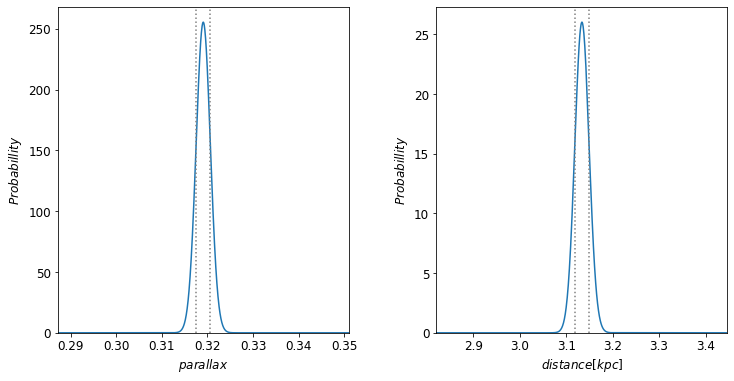

In [6]:
distance_NGC2506=distance_cluster(cluster_NGC2506)

### 3)
I choose the galaxy cluster Westerlund 2 ,I remove stars with membership probability smaller than 1 (PMemb<1)
and by the function of the previous part I calculate and plot the posterior pdf of parallax and distance.Also,the distance of this cluster is calculated with the same way as before (maximum likelihood estimate).

Cluster distance (based on maximum likelihood estimate): 5.275125296755473 ± 0.1712706586253252 kpc


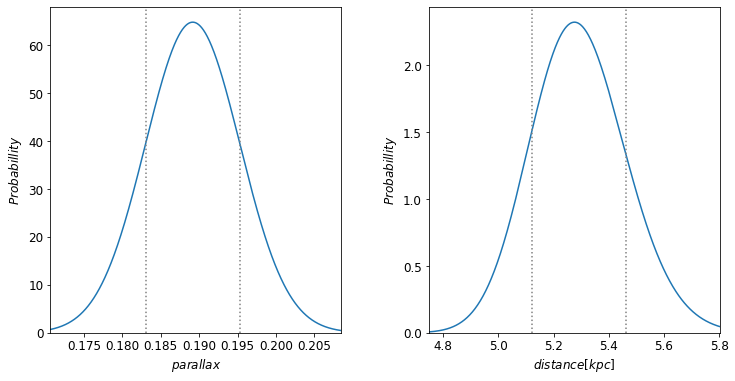

In [7]:
cluster_Westerlund_2= cnew[cnew.Cluster=='Westerlund_2']
cluster_Westerlund_2=cluster_Westerlund_2[cluster_Westerlund_2.PMemb>=1]
distance_Westerlund_2=distance_cluster(cluster_Westerlund_2)

Finally, I plot the  Westerlund 2 and NGC2506 in the same scatter plot of the values $('BP-RP'(colour))-Absolute$ $ G_{magnitude}$,with the $Absolute$ $G_{magnitude}$ at 10 pc being calculated by:

$M=m- 5 \cdot log_{10}(d)-10$,with d:distance in kpc,M:absolute magnitude,m:apparent magnitude.
The reason for using the  $Absolute$ $G_{magnitude}$ is due to the different distances of each cluster from the earth,with the  $G_{magnitude}(apparent)$ being highly affected by the distance.

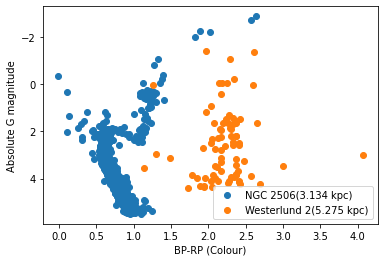

In [8]:
plt.scatter(cluster_NGC2506['BP-RP'],cluster_NGC2506['Gmag']-5*np.log10(distance_NGC2506)-10)
plt.scatter(cluster_Westerlund_2['BP-RP'],cluster_Westerlund_2['Gmag']-5*np.log10(distance_Westerlund_2)-10)
plt.gca().invert_yaxis()
plt.xlabel("BP-RP (Colour)")
plt.ylabel("Absolute G magnitude")
plt.legend(["NGC 2506("+str(round(distance_NGC2506,3))+" kpc)",
            "Westerlund 2("+str(round(distance_Westerlund_2,3))+" kpc)"])


The $('BP-RP'(colour))-Absolute G_{magnitude}$ plot can show very interesting characteristics of galaxies such as
their composition of elements and their average temperature,leading to categorizing galaxies appropriately.